In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
import outgas_calc as calc

# Python Impurity Model B
Starting from the ground up. Less modularity for now. Contains specific references to certain datasets from a PTFE/Oxygen setup.
## Constants
The following are constants for the Teflon/Oxygen pair.

In [3]:
ACTIVATION_ENERGY = 0.46 # activation energy in eV
D_0 = 26 # Diffusion constant at infinite temperature, in cm^2/s
SOLUBILITY = 0.22 # fractional volume of gas per volume of polymer
O2_ABUNDANCE = 0.21
ATMOS_PRESSURE = 101325 # in Pa
INITIAL_TEMP = 293 # in kelvin
THICKNESS = 0.75 # of sample, in cm
SURFACE_AREA = 62.02 # surface area of sample, in cm^2
k_b = 1.381e-22 # Boltzmann constant in mbar-liters/kelvin
CHAMBER_VOL = 5.0 # in Liters. Currently made up
INIT_PRESSURE = 1e-6 # Initial partial pressure in the chamber. Made up
CHAMBER_CONDUCTANCE = 10 # L/s

## Temperature Profile

In [4]:
lin_temp_times = np.arange(3601)
lin_temp_vals = np.concatenate((np.full(400, 293), np.linspace(293, 460, num=2200), np.full(1001, 460)))
lin_temp_profile = pd.DataFrame([lin_temp_times, lin_temp_vals]).T
lin_temp_profile.columns = ['time', 'temperature']

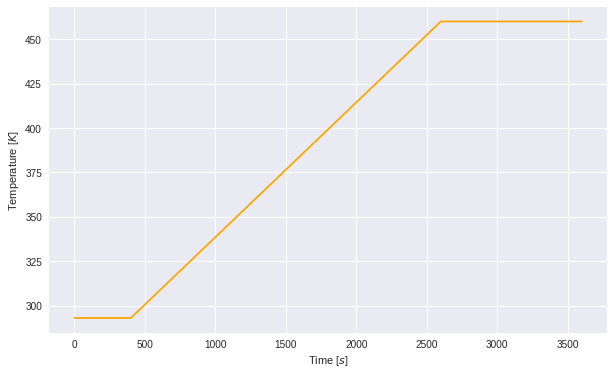

In [5]:
fix, ax = plt.subplots(figsize=(10,6))
plt.plot(lin_temp_times, lin_temp_vals, color='orange')

ax.set_ylabel('Temperature [$K$]')
ax.set_xlabel('Time [$s$]')

plt.show()

Calculate the initial concentration of $O_2$ in the sample. Last constant of the setup.

In [6]:
c_0 = calc.get_initial_concentration(SOLUBILITY, O2_ABUNDANCE, ATMOS_PRESSURE, INITIAL_TEMP) # result in cm^-3
c_0

1.1569039104571305e+18

Calculate the diffusion constants for all temperatures in the dataset.

In [7]:
diff_consts = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, lin_temp_profile['temperature'])
#diff_consts

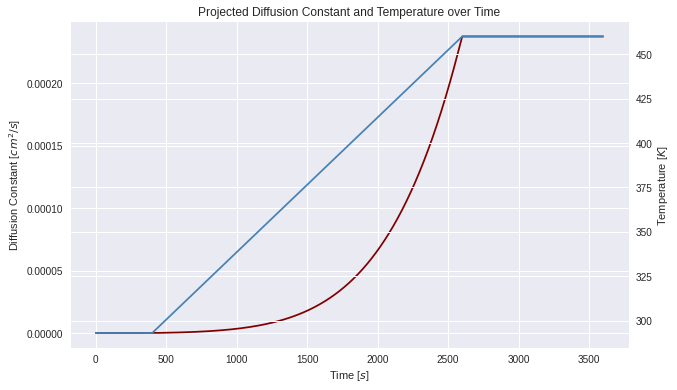

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(lin_temp_profile['time'], diff_consts, color='maroon')

ax.set_title('Projected Diffusion Constant and Temperature over Time')
#ax.set_yscale('log')
ax.set_xlabel('Time [$s$]')
ax.set_ylabel('Diffusion Constant [$cm^2/s$]')

ax2 = plt.twinx()
ax2.plot(lin_temp_profile['time'], lin_temp_profile['temperature'], color='steelblue')
ax2.set_ylabel('Temperature [$K$]')

plt.show()

Calculate the concentration and outgassing rate for the setup.

In [9]:
conc = calc.get_concentrations(c_0, diff_consts, THICKNESS, lin_temp_times)
# convert concentration from atoms per cm^2 to mbar-liters
conc = conc * SURFACE_AREA
conc = conc * k_b * lin_temp_vals
rates = calc.get_flow_rate(c_0, diff_consts, THICKNESS, lin_temp_times)
# convert rates from atoms per cm^2 per second to mbar-liters / second
rates = rates * SURFACE_AREA
rates = rates * k_b * lin_temp_vals

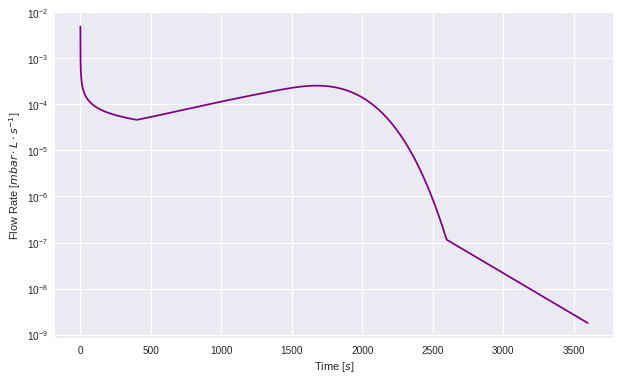

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(lin_temp_times, rates, color='purple')

ax.set_yscale('log')
ax.set_ylabel('Flow Rate [$mbar\cdot L \cdot s^{-1}$]')
ax.set_xlabel('Time [$s$]')

plt.show()

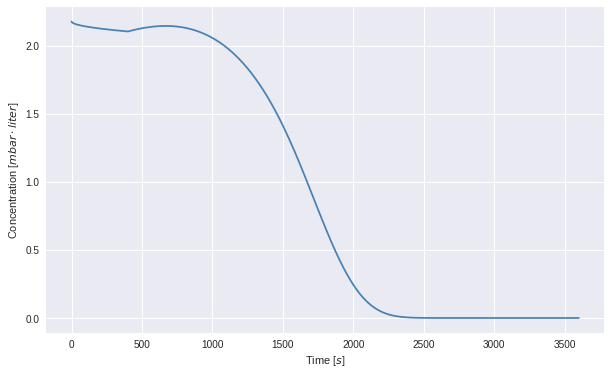

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(lin_temp_times, conc, color='steelblue')
#plt.yscale('log')
plt.ylabel('Concentration [$mbar\cdot liter$]')
plt.xlabel('Time [$s$]')
plt.show()

In [12]:
partial_pressure = rates/CHAMBER_CONDUCTANCE
partial_pressure

array([4.92700134e-04, 9.23979243e-05, 6.53351988e-05, ...,
       1.80474372e-10, 1.79724678e-10, 1.78978097e-10])

In [13]:
synthetic_pressure = pd.DataFrame(data=[lin_temp_times[::20], lin_temp_vals[::20], partial_pressure[::20]*0.7501]).T
synthetic_pressure.columns = ['time', 'temperature', 'pressure']
synthetic_pressure.to_csv('synth_partial_pressure.csv')

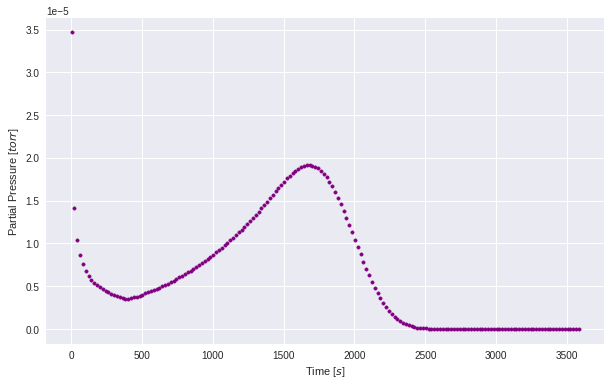

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(lin_temp_times[4::20], partial_pressure[4::20]*0.7501, marker='.', color='purple')

#ax.set_yscale('log')
ax.set_ylabel('Partial Pressure [$torr$]')
ax.set_xlabel('Time [$s$]')

plt.show()

In [15]:
def pressure_fit(tT, A, b, c):
    """Outputs the partial pressure for a given time (after the start of the temperature jump) and temperature.
    
    Arguments:
    tT: a (2,M) numpy array of time and temperature values, where M is the number of observations in the jump.
    A: the scaling parameter for the jump. Accounts for variables such as the initial concentration, etc.
    b: the activation energy (multiplied by k_B) in kelvins.
    c: the time constant which is proportional to the diffusion constant."""
    
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [16]:
lin_temp_profile.T.to_numpy()

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 3.598e+03, 3.599e+03,
        3.600e+03],
       [2.930e+02, 2.930e+02, 2.930e+02, ..., 4.600e+02, 4.600e+02,
        4.600e+02]])

In [17]:
synth2_pressure = pressure_fit(lin_temp_profile.T.to_numpy(), 1.83972747e+00, 4.12339864e+03, 2.22077592e+01)

In [18]:
synth2_pressure

array([1.42204376e-06, 1.42201935e-06, 1.42199494e-06, ...,
       8.54817466e-09, 8.52392060e-09, 8.49973535e-09])

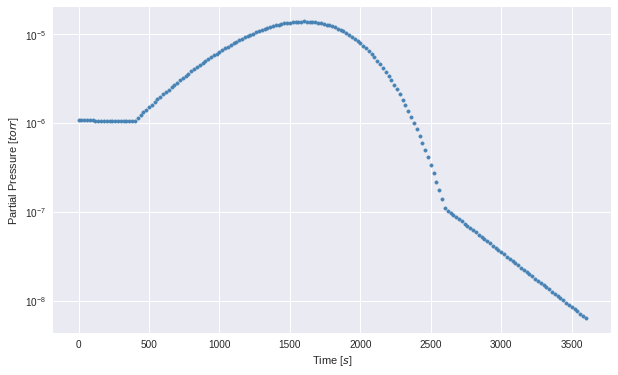

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(lin_temp_times[::20], synth2_pressure[::20]*0.7501, marker='.', color='steelblue')

ax.set_yscale('log')
ax.set_ylabel('Partial Pressure [$torr$]')
ax.set_xlabel('Time [$s$]')

plt.show()

In [20]:
synth2 = pd.DataFrame(data=[lin_temp_times[::20], lin_temp_vals[::20], synth2_pressure[::20]]).T
synth2.columns = ['time', 'temperature', 'pressure']
synth2.to_csv('synth2.csv')

## Exponential Profile

In [21]:
def exp_temp(t, k, T_i, T_f):
    """Return temperature profile which asymptotically approaches a T_f.
    
    Arguments:
    t: array of times
    k: time constant (how long to get 1-1/e of the way to the final temp)
    T_i: initial temperature
    T_f: final temperature
    """
    scale = T_f - T_i
    return T_f - scale * np.exp(-1./k*t)

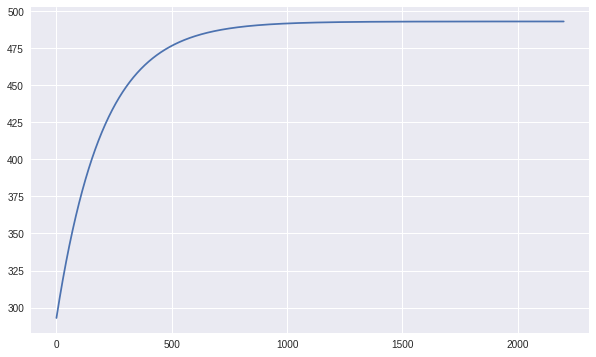

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

t = np.linspace(0, 2200, num=2200)
ax.plot(t, exp_temp(t, 200, 293, 493))

plt.show()

In [23]:
exp_temp_times = np.arange(3601)
exp_temp_vals = np.concatenate((np.full(400, 293), exp_temp(np.arange(0, 2200, 1), 200, 293, 460), np.full(1001, 460)))
exp_temp_profile = pd.DataFrame([exp_temp_times, exp_temp_vals]).T
exp_temp_profile.columns = ['time', 'temperature']

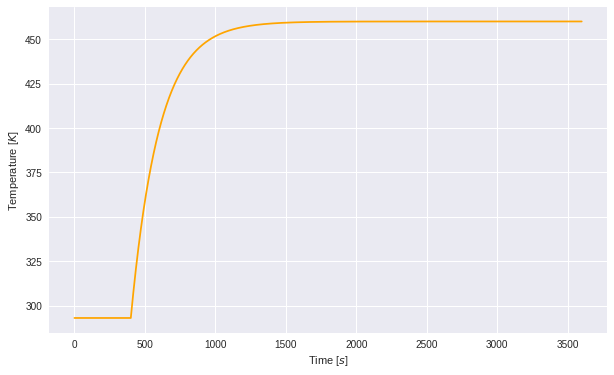

In [24]:
fix, ax = plt.subplots(figsize=(10,6))
plt.plot(exp_temp_times, exp_temp_vals, color='orange')

ax.set_ylabel('Temperature [$K$]')
ax.set_xlabel('Time [$s$]')

plt.show()

In [25]:
diff_consts = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, exp_temp_profile['temperature'])
#diff_consts

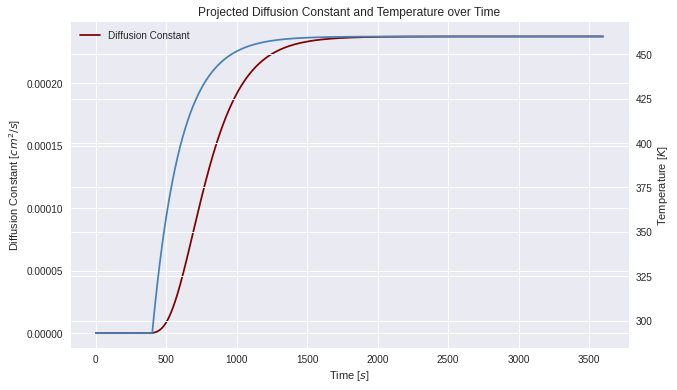

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(exp_temp_profile['time'], diff_consts, color='maroon', label='Diffusion Constant')

ax.set_title('Projected Diffusion Constant and Temperature over Time')
#ax.set_yscale('log')
ax.set_xlabel('Time [$s$]')
ax.set_ylabel('Diffusion Constant [$cm^2/s$]')

ax2 = plt.twinx()
ax2.plot(exp_temp_profile['time'], exp_temp_profile['temperature'], color='steelblue', label='Temperature')
ax2.set_ylabel('Temperature [$K$]')

ax.legend()

plt.show()

In [27]:
conc = calc.get_concentrations(c_0, diff_consts, THICKNESS, exp_temp_times)
# convert concentration from atoms per cm^2 to mbar-liters
conc = conc * SURFACE_AREA
conc = conc * k_b * lin_temp_vals
rates = calc.get_flow_rate(c_0, diff_consts, THICKNESS, exp_temp_times)
# convert rates from atoms per cm^2 per second to mbar-liters / second
rates = rates * SURFACE_AREA
rates = rates * k_b * lin_temp_vals

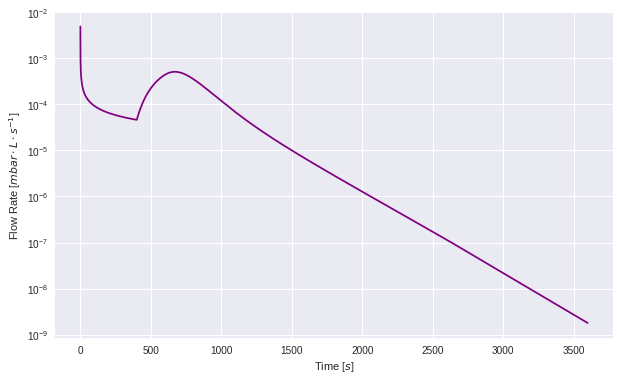

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(lin_temp_times, rates, color='purple')

ax.set_yscale('log')
ax.set_ylabel('Flow Rate [$mbar\cdot L \cdot s^{-1}$]')
ax.set_xlabel('Time [$s$]')

plt.show()

In [29]:
partial_pressure = rates/CHAMBER_CONDUCTANCE
partial_pressure

array([4.92700134e-04, 9.23979243e-05, 6.53351988e-05, ...,
       1.80474372e-10, 1.79724678e-10, 1.78978097e-10])

In [30]:
synthetic_pressure = pd.DataFrame(data=[exp_temp_times[2::20], exp_temp_vals[2::20], partial_pressure[2::20]*0.7501]).T
synthetic_pressure.columns = ['time', 'temperature', 'pressure']
# add noise
synthetic_pressure['pressure'] = np.abs(synthetic_pressure['pressure'] + np.random.normal(scale=1.0e-9, size=synthetic_pressure['pressure'].shape[0]))
synthetic_pressure.to_csv('synth_3_exp.csv')

In [31]:
synthetic_pressure['pressure']

0      4.900767e-05
1      1.477625e-05
2      1.069590e-05
3      8.799523e-06
4      7.656078e-06
           ...     
175    5.705305e-10
176    3.373090e-10
177    3.769253e-10
178    2.759318e-11
179    1.341132e-09
Name: pressure, Length: 180, dtype: float64

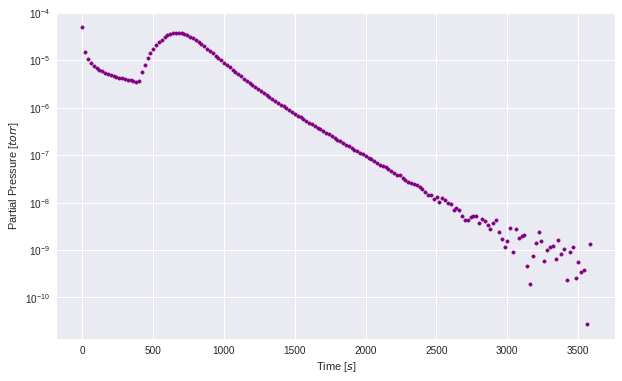

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(synthetic_pressure['time'], synthetic_pressure['pressure'], marker='.', color='purple')

ax.set_yscale('log')
ax.set_ylabel('Partial Pressure [$torr$]')
ax.set_xlabel('Time [$s$]')

plt.show()

## Diffusion Constant from Real Temperature Data
The cause of the degeneracy in the real pressure data is still a mystery. It is suspected that if the temperature and diffusion constant are exactly proportional, this might cause the degeneracy. This section will determine if there is such proportionality between the temperature and diffusion constant from the real data. The data import code comes from `Analysis_Buildup.ipynb`. The run used is from Nov. 9, 2020.

In [4]:
run_label = '2021_05_03' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

Checking the CO2 table:

In [5]:
gas_tables[4]

,exp_time,pressure,ch1_lerp,ch2_lerp,mean_temp
1269901,0.0,1.600000e-09,296.8,296.9,296.85
3663166,42.0,1.980000e-09,296.8,296.9,296.85
1859546,83.0,1.720000e-09,296.8,296.9,296.85
2934781,125.0,1.890000e-09,296.8,296.9,296.85
255117,166.0,1.860000e-09,296.8,296.9,296.85
...,...,...,...,...,...
494939,174027.0,1.700000e-09,299.0,298.3,298.65
3233072,174068.0,2.200000e-09,298.9,298.3,298.60
533588,174110.0,1.940000e-09,298.9,298.3,298.60
3883168,174151.0,1.840000e-09,298.9,298.3,298.60


In [6]:
CO2_table = gas_tables[4]

In [25]:
CO2_jump4_table = CO2_table[CO2_table['exp_time'].between(3000, 27200)].reset_index(drop=True)

In [26]:
CO2_diff_consts = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, CO2_table['ch1_lerp'])

In [27]:
CO2_j4_diff_consts = calc.arrhenius_relation(D_0, ACTIVATION_ENERGY, CO2_jump4_table['ch1_lerp'])

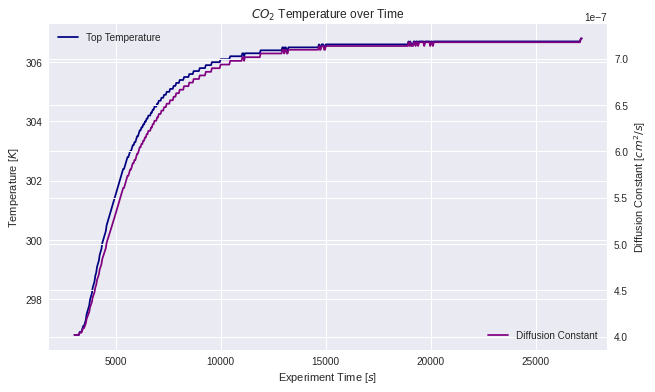

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

# Experiment time converted to hours
ax.plot(CO2_jump4_table['exp_time'], CO2_jump4_table['ch1_lerp'], label='Top Temperature', color='navy')
#ax.plot(CO2_table['exp_time']/3600, CO2_table['mean_temp'], label='Simple Mean Temperature', color='gray')
#ax.plot(CO2_table['exp_time']/3600, CO2_table['ch2_lerp'], label='Bottom Temperature', color='darkorange')

ax2 = plt.twinx()
ax2.plot(CO2_jump4_table['exp_time'], CO2_j4_diff_consts, label='Diffusion Constant', color='purple')

ax.set_title('$CO_2$ Temperature over Time')
ax.set_xlabel('Experiment Time [$s$]')
ax.set_ylabel('Temperature [$K$]')
ax2.set_ylabel('Diffusion Constant [$cm^2/s$]')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.show()

If the diffusion constant $D$ is proportional to $T$, then this breaks down the fitting equation.
$$\exp\left(-\frac{b}{T}\right)=\lambda T$$
$$p(t,T) = A\cdot\lambda T \exp\left(-c\cdot t\cdot\lambda\cdot T\right)$$